<a href="https://colab.research.google.com/github/ReidelVichot/DEFreightProfiles/blob/main/Roads_Tracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 21.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import CCD from google drive Source: Census
ccd_name = "/content/drive/My Drive/FreightProfiles/tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(ccd_name)
# Import tracks from google drive
# Source: Fist Maps
# https://de-firstmap-delaware.hub.arcgis.com/datasets/railroad-rail-lines/explore?location=39.655622%2C-75.765561%2C13.56
rail_name = "/content/drive/MyDrive/FreightProfiles/Delaware_Multimodal_2.0_tracks/Delaware_Multimodal_2.0.shp"
rail = gpd.read_file(rail_name)

In [5]:
ccd = ccd.to_crs("EPSG:2235")
rail = rail.to_crs("EPSG:2235");

In [19]:
ccd.columns

Index(['STATEFP', 'COUNTYFP', 'COUSUBFP', 'COUSUBNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CNECTAFP', 'NECTAFP',
       'NCTADVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

In [22]:
cols = ['NAME','geometry']
ccd = ccd[cols]

In [29]:
cols = ['TRACK_TYPE', 'STATUS', 'LINE_ID', 'OWNER', 'geometry']
rail = rail[cols]

In [38]:
rail.STATUS.unique()

array(['Active', 'Inactive'], dtype=object)

In [34]:
rail[rail.STATUS=="Active"].head()

,TRACK_TYPE,STATUS,LINE_ID,OWNER,geometry
0,Industry,Active,Delmarva Secondary,Norfolk Southern Corporation,"LINESTRING (621911.241 415834.465, 621879.679 ..."
1,Industry,Active,Delmarva Secondary,Norfolk Southern Corporation,"LINESTRING (621516.832 415610.758, 621483.946 ..."
2,Industry,Active,Delmarva Secondary,Norfolk Southern Corporation,"LINESTRING (619813.748 417190.705, 619771.837 ..."
3,Main,Active,Delmarva Secondary,Norfolk Southern Corporation,"LINESTRING (595823.092 468347.189, 595724.533 ..."
4,Main,Active,Delmarva Secondary,Norfolk Southern Corporation,"LINESTRING (608681.086 443228.853, 608580.796 ..."


In [6]:
#ccd = ccd.to_crs(rail.crs)

# Get the intersection of the line and the polygon
intersection = gpd.overlay(rail, ccd[ccd["NAME"]=="Newark"], how="intersection")


# Get the length of the intersection
intersection.length.sum()

# Print the result
#print(f"The length of the line within the polygon is {length:.2f} units.")

222102.76168900417

                                             length_ft  length_miles
OWNER                                                               
CSX Transportation                        27370.423085      5.183794
National Railroad Passenger Corporation  173582.345333     32.875455
Norfolk Southern Corporation              13594.687556      2.574752


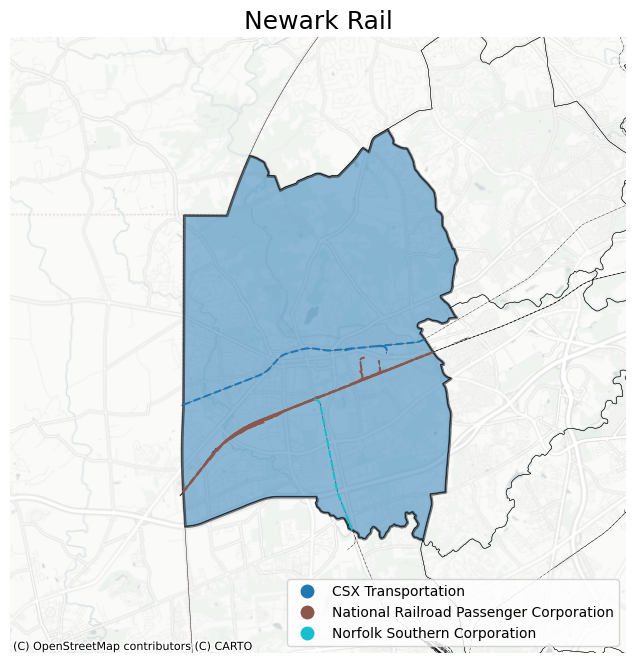

In [40]:
import contextily as cx

CCD = "Newark"
resol = 30000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol

fig, ax = plt.subplots(figsize=(8,8))

plt.title(CCD + " Rail", fontdict={"fontsize":18})

ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
rail.plot(color="k", linestyle="-.", lw = 0.3, ax=ax)

intersect = gpd.overlay(rail[rail.STATUS=="Active"], ccd[ccd["NAME"]==CCD], how="intersection")
intersect.plot("OWNER", linestyle="--", ax=ax,
                        legend=True,
                        legend_kwds={'loc':"lower right"})

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
fig.show()

intersect["length_ft"] = intersect.length
intersect["length_miles"] = intersect.length_ft * 0.000189394

print(intersect.groupby("OWNER").sum(numeric_only = True)[["length_ft", "length_miles"]])

In [8]:
gpd.overlay(rail, ccd[ccd["NAME"]==CCD], how="intersection").groupby("OWNER").sum()

<ipython-input-8-d7d17ed979ee>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gpd.overlay(rail, ccd[ccd["NAME"]==CCD], how="intersection").groupby("OWNER").sum()


,OBJECTID,RAIL_ID,SHAPELEN,ALAND,AWATER
OWNER,,,,,
CSX Transportation,2925,3891,21867.001418,545488839,107562
National Railroad Passenger Corporation,92962,105416,87951.279737,8182332585,1613430
Norfolk Southern Corporation,2877,6427,5772.464635,233780931,46098


In [9]:
gpd.overlay(rail, ccd[ccd["NAME"]==CCD], how="intersection").crs

<Projected CRS: EPSG:2235>
Name: NAD83 / Delaware (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Delaware - counties of Kent; New Castle; Sussex.
- bounds: (-75.8, 38.44, -74.97, 39.85)
Coordinate Operation:
- name: SPCS83 Delaware zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
#road_invent = gpd.read_file("/content/drive/MyDrive/FreightProfiles/Delaware_Road_Inventory_2.0 (2)/Delaware_Road_Inventory_2.0.shp")

In [13]:
CFC = gpd.read_file("/content/drive/MyDrive/FreightProfiles/Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0 (1)/Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0.shp")
CFC = CFC.to_crs("EPSG:2235")

In [14]:
#Freight Movement Bottlenecks
FMB = gpd.read_file("/content/drive/MyDrive/FreightProfiles/FreightMovementBottlenecks/Delaware_Multimodal_2.0.shp")
FMB = FMB.to_crs("EPSG:2235")

In [15]:
FMB.columns

Index(['OBJECTID', 'TMC_CODE', 'CORRIDOR_I', 'DESCRIPTIO', 'NAME', 'MILES',
       'TMC', 'TMCTYPE', 'ROADNUMBER', 'ROADNAME', 'ISPRIMARY', 'COUNTY',
       'ZIP', 'DIRECTION', 'URBAN_CODE', 'FACILTYPE', 'STRUCTYPE',
       'HOURLY_CAP', 'TOTAL_THRU', 'TOTAL_CAPA', 'ROUTE_NUMB', 'ROUTE_SIGN',
       'ROUTE_QUAL', 'ALTRTENAME', 'TOTAL_AADT', 'UNIT_TRUCK', 'COMBINATIO',
       'TRUCK', 'AM_PEAK_RE', 'PM_PEAK_RE', 'SUM_PEAK_R', 'AM_RELIABI',
       'PM_RELIABI', 'SUMMER_REL', 'HOURLY_C00', 'TRUCK_AADT', 'TRUCK_PERC',
       'UNIT_PERCE', 'COMBINAT00', 'BOTTLENECK', 'PRIORITY', 'RANK',
       'geometry'],
      dtype='object')

In [41]:
FMB.TRUCK_PERC

0          7% to 9%
1          7% to 9%
2          7% to 9%
3         9% to 11%
4         9% to 11%
5          7% to 9%
6          7% to 9%
7          7% to 9%
8          7% to 9%
9         9% to 11%
10        9% to 11%
11         7% to 9%
12    11% and Above
13         7% to 9%
14         7% to 9%
Name: TRUCK_PERC, dtype: object

In [17]:
CFC.length * 0.000189394

0      4.124179
1      2.823466
2      0.815235
3      1.630089
4      1.704565
5      5.901573
6      2.450157
7      6.425413
8      5.516843
9      4.660229
10     2.227895
11     0.662741
12     0.741035
13     0.928668
14     0.404078
15     1.434925
16    26.074560
17     1.378032
18    17.751372
19     3.736288
20     2.377973
21     1.332453
22     0.374783
23     1.271331
24     4.074257
25    19.689312
26     0.804012
27     1.002108
28     0.298515
29     5.938863
30     5.089636
31     1.816864
32    11.172195
33    10.456265
34     4.763832
35    24.655174
36    37.264276
37     0.479434
38     5.660920
39    11.501132
40    23.442521
dtype: float64

In [56]:
CFC['FREIGHT_NE'].unique()

array(['CUFC', 'CRFC', 'PFN'], dtype=object)

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


            LENGTH     length_ft  length_miles
FREIGHT_NE                                    
CRFC          7.04  24549.618489      4.649550
CUFC         16.47  77116.202163     14.605346
              UNIT_TRUCK
ROADNAME                
Bay Rd              2682
Forrest Ave         4598
S Dupont Hwy       26528


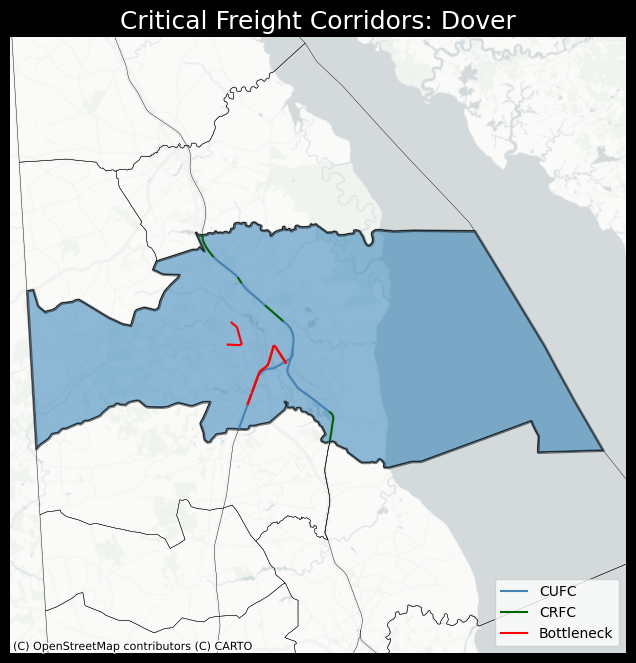

In [83]:
import contextily as cx

CCD = "Dover"
resol = 85000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol

font = {'color':  'white',
        'weight': 'normal',
        'size': 18}

fig, ax = plt.subplots(figsize=(8,8), facecolor="k")

plt.title("Critical Freight Corridors: " + CCD, fontdict=font)

ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
CFC.plot(color="k", linestyle="-", lw = 0.3, ax=ax)


intersect = gpd.overlay(CFC, ccd[ccd["NAME"]==CCD],
            how="intersection")

intersect[intersect["FREIGHT_NE"]=='CUFC'].plot(linestyle="-", ax=ax,
                             label = 'CUFC', color="steelblue");
intersect[intersect["FREIGHT_NE"]== 'CRFC'].plot(linestyle="-", ax=ax,
                             label = 'CRFC', color="darkgreen");
intersect[intersect["FREIGHT_NE"]== 'PFN'].plot(linestyle="-", ax=ax,
                             label = 'PFN', color="peru");

bottleneck_intersect = gpd.overlay(FMB, ccd[ccd["NAME"]==CCD],
            how="intersection")

bottleneck_intersect.plot("ROADNAME", linestyle="-", ax=ax,
                             label = "Bottleneck", color="red");

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')
fig.show()

intersect["length_ft"] = intersect.length
intersect["length_miles"] = intersect.length_ft * 0.000189394
print(intersect.groupby("FREIGHT_NE").sum(numeric_only = True)[["LENGTH", "length_ft", "length_miles"]])
print(bottleneck_intersect.groupby("ROADNAME").sum(numeric_only = True)[["UNIT_TRUCK"]])